In [216]:
!pip install torchdata

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [217]:
!wget https://files.grouplens.org/datasets/movielens/ml-1m.zip
!unzip ml-1m.zip

--2022-08-07 12:36:23--  https://files.grouplens.org/datasets/movielens/ml-1m.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5917549 (5.6M) [application/zip]
Saving to: ‘ml-1m.zip.1’

ml-1m.zip.1         100%[===================>]   5.64M  13.5MB/s    in 0.4s    

2022-08-07 12:36:24 (13.5 MB/s) - ‘ml-1m.zip.1’ saved [5917549/5917549]

Archive:  ml-1m.zip
replace ml-1m/movies.dat? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [218]:
import torch
from torch import nn, div, square, norm
from torch.nn import functional as F
from torchdata import datapipes as dp
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import time

In [219]:
datapath = 'ml-1m/'
seed = 12
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [220]:
num_users = pd.read_csv(datapath + 'users.dat',
            delimiter='::',
            engine='python',
            encoding='latin-1',
            header=None)[0].max()
num_items = pd.read_csv(datapath + 'movies.dat',
            delimiter='::',
            engine='python',
            encoding='latin-1',
            header=None)[0].max()

In [221]:
num_users, num_items

(6040, 3952)

In [222]:
train_items, test_items = train_test_split(torch.arange(num_items),
                                           test_size=0.2,
                                           random_state=seed)
train_items.size(), test_items.size()

(torch.Size([3161]), torch.Size([791]))

In [223]:
# create global user_item matrix and mask matrix
user_item_mat = torch.zeros((num_users, num_items))

In [224]:
ratings = pd.read_csv(datapath + 'ratings.dat',
            encoding='latin-1',
            header=None,
            engine='python',
            delimiter='::')

In [225]:
def create_data_from_line(line):
    user_id, item_id, rating, *_ = line
    user_item_mat[user_id - 1, item_id - 1] = rating
    return None

In [226]:
ratings.T.apply(create_data_from_line);

In [227]:
torch.where(user_item_mat == 0, 1, 0).sum() / (num_users * num_items)

tensor(0.9581)

In [228]:
def collate_fn(batch):
    return torch.LongTensor(batch)

In [229]:
def create_datapipe_from_array(array, mode='train', batch_size=32, len=1000):
    pipes = dp.iter.IterableWrapper(array)
    pipes = pipes.shuffle(buffer_size=len)
    pipes = pipes.sharding_filter()
    
    if mode == 'train':
        pipes = pipes.batch(batch_size, drop_last=True)
    else:
        pipes = pipes.batch(batch_size)
    
    pipes = pipes.map(collate_fn)
    return pipes

In [230]:
batch_size = 512

train_dp = create_datapipe_from_array(train_items, batch_size=batch_size)
test_dp = create_datapipe_from_array(test_items, mode='test', batch_size=batch_size)

In [231]:
num_workers = 2

train_dl = DataLoader(dataset=train_dp, shuffle=True, num_workers=num_workers)
test_dl = DataLoader(dataset=test_dp, shuffle=False, num_workers=num_workers)

In [232]:
class AutoRec(nn.Module):
    def __init__(self, d, k, dropout):
        super().__init__()
        self.seq = nn.Sequential(
            nn.Linear(d, k),
            nn.Sigmoid(),
            nn.Dropout(dropout),
            nn.Linear(k, d)
        )
    
    def forward(self, r):
        return self.seq(r)

In [233]:
def train_epoch(model, dl, opt, criterion):
    list_loss = []
    start_time = time.perf_counter()
    for batch_idx, items_idx in enumerate(dl):
        r = user_item_mat[:, items_idx].squeeze().permute(1, 0).to(device)
        r_hat = model(r)
        loss = criterion(r, r_hat * torch.sign(r))
        
        list_loss.append(loss.item())
        if batch_idx % 50 == 0:
            log_time = round(time.perf_counter() - start_time, 4)
            print("Loss {:.2f} | {:.4f}s".format(loss.item(), log_time))
        
        opt.zero_grad()
        loss.backward()
        opt.step()

    return list_loss

In [234]:
def eval_epoch(model, dl, criterion):
    model.eval()
    truth = []
    predict = []
    size = 0
    list_loss = []
    start_time = time.perf_counter()
    with torch.no_grad():
        for batch_idx, items_idx in enumerate(dl):
            r = user_item_mat[:, items_idx].squeeze().permute(1, 0).to(device)

            r_hat = model(r)

            truth.append(r)
            predict.append(r_hat * torch.sign(r))

            loss = criterion(r, r_hat * torch.sign(r))

            list_loss.append(loss.item())
            if batch_idx % 30 == 0:
                log_time = round(time.perf_counter() - start_time, 4)
                print("Loss {:.2f} | {:.4f}s".format(loss.item(), log_time))

    rmse = torch.Tensor([torch.sqrt(square(r - r_hat).sum() / torch.sign(r).sum())
                            for r, r_hat in zip(truth, predict)]).mean().item()

    return list_loss, rmse

In [235]:
model = AutoRec(d=num_users, k=500, dropout=0.1).to(device)
opt = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)
criterion = nn.MSELoss()

In [236]:
max_epochs = 50
losses = []
val_losses = []

In [237]:
for epoch in range(max_epochs):
    print("=" * 10 + f"Epoch: {epoch}" + "=" * 10)
    epoch_loss = train_epoch(model, train_dl, opt, criterion)
    val_loss, *_ = eval_epoch(model, test_dl, criterion)
    losses.extend(epoch_loss)
    val_losses.extend(val_loss)

==========Epoch: 0==========
Loss 0.59 | 0.2356s
Loss 0.54 | 0.1589s
==========Epoch: 1==========
Loss 0.55 | 0.2135s
Loss 0.48 | 0.1595s
==========Epoch: 2==========
Loss 0.51 | 0.2272s
Loss 0.41 | 0.1534s
==========Epoch: 3==========
Loss 0.44 | 0.2134s
Loss 0.35 | 0.1566s
==========Epoch: 4==========
Loss 0.35 | 0.2143s
Loss 0.29 | 0.1566s
==========Epoch: 5==========
Loss 0.25 | 0.2056s
Loss 0.23 | 0.1564s
==========Epoch: 6==========
Loss 0.27 | 0.2140s
Loss 0.19 | 0.1540s
==========Epoch: 7==========
Loss 0.18 | 0.2067s
Loss 0.15 | 0.2144s
==========Epoch: 8==========
Loss 0.15 | 0.3967s
Loss 0.12 | 0.2766s
==========Epoch: 9==========
Loss 0.12 | 0.3534s
Loss 0.10 | 0.1552s
==========Epoch: 10==========
Loss 0.10 | 0.2123s
Loss 0.08 | 0.1589s
==========Epoch: 11==========
Loss 0.08 | 0.2106s
Loss 0.07 | 0.1638s
==========Epoch: 12==========
Loss 0.08 | 0.2132s
Loss 0.06 | 0.1657s
==========Epoch: 13==========
Loss 0.06 | 0.2158s
Loss 0.06 | 0.1507s
==========Epoch: 14==========


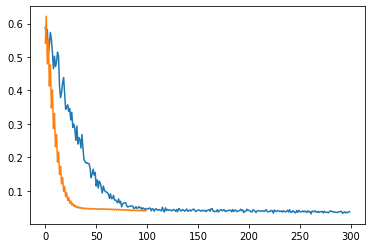

In [238]:
plt.plot(losses)
plt.plot(val_losses)
plt.show()

In [240]:
val_loss, rmse = eval_epoch(model, test_dl, criterion)
rmse

Loss 0.04 | 0.3046s


0.9463635087013245